In [2]:
%matplotlib inline

import warnings
import itertools    
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Flatten, LSTM, Input, Dropout, BatchNormalization, GRU
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

sns.set_style('dark')

warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../input/eeg-brainwave-dataset-feeling-emotions/emotions.csv')
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [5]:
# Checking for missing values
for col in df.columns:
    if(df[col].isnull().sum()>0):
        print(col)
# NO missing value

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=200, figsize=(24, 12))

df.loc[0, 'fft_0_b':'fft_749_b'].plot(title='\"fft_0_b\" Through \"fft_749_b\" -- 1', color='tab:blue', ax=axes[0])
df.loc[10, 'fft_0_b':'fft_749_b'].plot(title='\"fft_0_b\" Through \"fft_749_b\" -- 10', color='tab:red', ax=axes[1])
df.loc[30, 'fft_0_b':'fft_749_b'].plot(title='\"fft_0_b\" Through \"fft_749_b\" -- 30', color='tab:green', ax=axes[2])

plt.subplots_adjust(left=0.1, bottom=0.1, 
                    right=0.9, top=0.9, 
                    wspace=0.4, hspace=0.4)

In [10]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,0
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,1
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,2
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,2
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,1


In [11]:
data_a = np.array(df.loc[:,'fft_0_a':'fft_749_a'])
data_b = np.array(df.loc[:,'fft_0_b':'fft_749_b'])
data_c = np.array(df.drop('label', axis=1))

Y = df['label'].copy()
X = data_b.copy()

X_train, x_test, Y_train, y_test = train_test_split(X, Y,random_state=111, test_size=0.3)
X_train, x_val, Y_train, y_val=train_test_split(X_train, Y_train, random_state=111, test_size=0.3)

In [12]:
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
x_test = np.array(x_test).reshape((x_test.shape[0], x_test.shape[1],1))

Y_train = pd.get_dummies(Y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)

In [14]:
i_lstm = Input(shape=(X_train.shape[1], 1))

x_lstm = LSTM(100, return_sequences=True,dropout = 0.2)(i_lstm)
x_lstm = Flatten()(x_lstm)
y_lstm = Dense(3, activation='softmax')(x_lstm)

model_lstm = Model(i_lstm, y_lstm)


In [56]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_lstm_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
                                    
model_lstm.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])
        
lstm_h = model_lstm.fit(X_train, Y_train,
                   batch_size=32,
                   validation_data=(x_val, y_val),
                   epochs=50,callbacks=[es, mc, lr_schedule])

Epoch 1/50
33/33 [==============================] - 24s 678ms/step - loss: 1.7653 - accuracy: 0.7749 - val_loss: 2.2791 - val_accuracy: 0.8326

Epoch 00001: val_accuracy improved from -inf to 0.83259, saving model to ./best_lstm_model.h5
Epoch 2/50
33/33 [==============================] - 21s 652ms/step - loss: 1.0672 - accuracy: 0.8659 - val_loss: 0.5897 - val_accuracy: 0.8438

Epoch 00002: val_accuracy improved from 0.83259 to 0.84375, saving model to ./best_lstm_model.h5
Epoch 3/50
33/33 [==============================] - 23s 688ms/step - loss: 0.4475 - accuracy: 0.8918 - val_loss: 0.4487 - val_accuracy: 0.8549

Epoch 00003: val_accuracy improved from 0.84375 to 0.85491, saving model to ./best_lstm_model.h5
Epoch 4/50
33/33 [==============================] - 22s 655ms/step - loss: 0.2031 - accuracy: 0.9310 - val_loss: 0.3863 - val_accuracy: 0.8616

Epoch 00004: val_accuracy improved from 0.85491 to 0.86161, saving model to ./best_lstm_model.h5
Epoch 5/50
33/33 [=====================

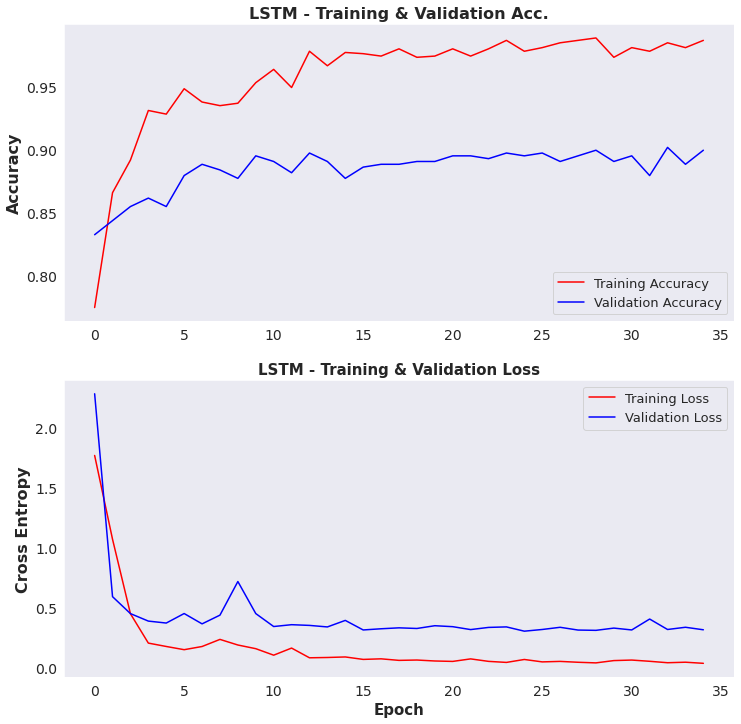

In [57]:
acc = lstm_h.history['accuracy']
val_acc = lstm_h.history['val_accuracy']

loss = lstm_h.history['loss']
val_loss = lstm_h.history['val_loss']


plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

In [59]:
lstm_best = load_model('./best_lstm_model.h5')
lstm_acc = lstm_best.evaluate(x_test, y_test, verbose=0)[1]
print("Test Acc.: {:.3f}%".format(lstm_acc * 100))

Test Acc.: 89.844%


In [51]:
y_pred = np.array(list(map(lambda x: np.argmax(x), lstm_best.predict(x_test))))
y_test = y_test.idxmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       190
           1       1.00      0.98      0.99       231
           2       0.97      0.85      0.91       219

    accuracy                           0.94       640
   macro avg       0.94      0.94      0.94       640
weighted avg       0.95      0.94      0.94       640



Normalized confusion matrix


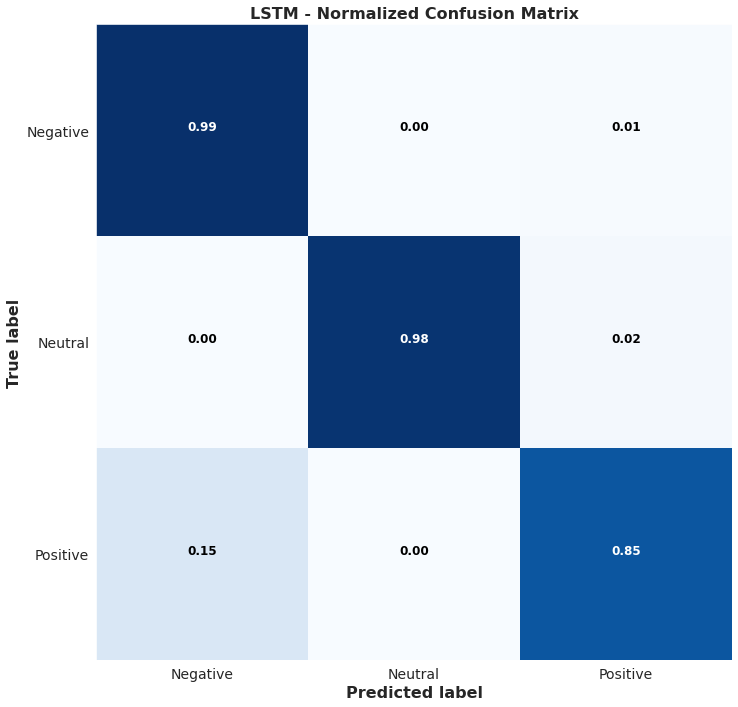

In [60]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

cnf_matrix = cm
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'], normalize=True,
                      title='LSTM - Normalized Confusion Matrix')
plt.show()